In [1]:
import numpy as np
from scipy.integrate import ode
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator
import pandas as pd

import mpmath as mpm

%matplotlib inline

In [204]:
#Define the redshift evolution of f_esc
f_esc_flag ='Power'
data_type = "tau_only"
#data_type = "marg_cosmo"

directory = '/Users/laynep/work/reionization/importance_sampler/python_implementation/'

class f_esc_funct():
    
    def __init__(self,f_esc_flag, f_esc_params):
        
        if f_esc_flag == "Power":
            self.f_esc = lambda z: self.f_esc_POWER(z, f_esc_params)
        elif f_esc_flag == "Tanh":
            self.f_esc = lambda z: self.f_esc_TANH(z, f_esc_params)
        elif f_esc_flag == "Polint":
            
            self.z_pos = np.linspace(3,15,5)
            self.f_polint = interp1d(z_pos, f_esc_params[0:5], kind='cubic')
            self.f_esc = self.f_esc_POLINT
        else:
            raise Exception('This f_esc_flag not implemented.')
        
        
    def f_esc_POWER(self, z, f_esc):
        f6 = f_esc[0]
        alpha = f_esc[1]
        
        out = f6*((1.0+z)/7.0)**alpha
        
        return np.min([np.max([0.0, out]), 1.0])
    
    def f_esc_POLINT(self, z):
        
        if z< np.min(self.z_pos):
            return f_esc[0]
        elif z>np.max(self.z_pos):
            return f_esc[-1]
        else:
            return np.min([np.max([0.0, self.f_polint(z)]), 1.0])
    
    def f_esc_TANH(self, z,f_esc):
        f_inf = f_esc[0]
        f_0 = f_esc[1]
        z_half = f_esc[2]
        dz = f_esc[3]
        
        f_out = 0.5*(f_inf-f_0)*np.tanh((z-z_half)/dz) + 0.5*(f_inf+f_0)
        return np.min([np.max([0.0, f_out]), 1.0])



#Fixed params
class global_params():
    
    def __init__(self):
        """Some general set up required."""
    
        self.m_bright = -35.0
        self.photon_norm_factor = 25.2
        
        self.T0_IGM = 2.0e4
        self.X_h = 0.747
        self.HeII_z = 3.5
        
        self.schecter_fname = directory + 'schecter_params.txt'
        schecter = np.loadtxt(self.schecter_fname)
        self.z_list = schecter[:,0]
        self.phi_list = schecter[:,1]
        self.m_list = schecter[:,2]
        self.alpha_list = schecter[:,3]
        
        self.mpc_to_cm = 3.086e24
        self.mass_h = 1.674e-24
        self.G_newton = 6.674e-8
        self.sigT = 6.6524e-25
        self.c = 2.998e10
        
        #Can also be iterated over
        self.h = 0.7
        #self.ommh2 = 0.27*self.h**2
        self.ommh2 = 0.3*self.h**2
        self.ombh2 = 0.045*self.h**2
        
        if data_type == "tau_only":
            self.tau_post_fname =directory + 'posterior_tauonly.txt'
            tau_pdf = np.loadtxt(self.tau_post_fname)
            self.tau_list = tau_pdf[:,1]
            self.taupdf_list = tau_pdf[:,0]
        elif data_type == "marg_cosmo":
            self.data_margcosmo = pd.read_csv(directory + 'total_margcosmo.txt')

    
globe = global_params()

def unpack(x):
    
    y = np.array(x)
    
    if f_esc_flag=="Power":
        offset=2
    elif f_esc_flag=="Polint":
        offset=5
    elif f_esc_flag=="Tanh":
        offset=4
    else:
        raise Exception('This f_esc_flag not supported.')
        
    f_esc_params = x[0:offset]
    c_hii = x[offset]
    m_sf = x[offset+1]
    m_evol = x[offset+2]
    
    if data_type == "tau_only":
        #Can get these either from x or from fixed
        ombh2 = globe.ombh2
        ommh2 = globe.ommh2
    elif data_type == "marg_cosmo":
        ombh2 = x[offset+3]
        ommh2 = x[offset+4]
    else:
        raise Exception('This data_type not supported.')
        
    return f_esc_params, c_hii, m_sf, m_evol, ombh2, ommh2

def mag_to_lumin(mag):
    """Converts AB magnitude to luminosity."""
    conv_factor = 4.345e20
    return float(conv_factor*10.0**(-mag/2.5))

def schecter_params(z):
    """Get the Schecter parameters as a function of redshift.  Based on the Scorch I paper."""

    #Use range limits if z extends beyond the interpolation list
    if z<np.min(globe.z_list):
        phi_star, m_star, alpha_star = globe.phi_list[0],globe.m_list[0],globe.alpha_list[0]
    elif z>np.max(globe.z_list):
        phi_star, m_star, alpha_star = globe.phi_list[-1], globe.m_list[-1], globe.alpha_list[-1]

    else:
        #Interpolate
        phi, m, alpha = map(lambda x: interp1d(globe.z_list,x,kind='cubic'),
                            [globe.phi_list, globe.m_list, globe.alpha_list])

        phi_star, m_star, alpha_star = phi(z), m(z), alpha(z)

    L_star = mag_to_lumin(m_star)

    #Convert phi into cgs --- currently Mpc^-3
    phi_star *= globe.mpc_to_cm**(-3.0)

    return float(phi_star), float(L_star), float(alpha_star)

def ioniz_emiss(z, m_sf, m_evol, f_esc):
    m_faint = m_sf + m_evol*(z-6.0)
    L_bright = mag_to_lumin(globe.m_bright)
    L_faint = mag_to_lumin(m_faint)

    phi_star, L_star, alpha = schecter_params(z)

    prefactor = -2.5/np.log(10.0)
    prefactor *= 10.0**(globe.photon_norm_factor)
    prefactor *= f_esc.f_esc(z)*phi_star*L_star
    
    if alpha<-2.0:
        #Close approximation
        return prefactor*(alpha+1.0)**(-1.0)*(L_faint/L_star)**(alpha+1.0)
    else:
        return prefactor*(mpm.gammainc(1.0+alpha,L_bright/L_star) - mpm.gammainc(1.0+alpha,L_faint/L_star))

def t_recomb(z, c_hii):
    prefactor = 0.93*1e9*365.25*24.0*60.0*60.0 #Gyr to sec
    c_term = (c_hii/3.0)**(-1.0)
    t_term = (globe.T0_IGM/2.0e4)**0.7
    z_term = ((1.0+z)/7.0)**(-3.0)
    return prefactor*c_term*t_term*z_term

def comov_h_density(ombh2):
    prefactor = (3.0/8.0/np.pi/globe.G_newton)*1e4*(1e5/globe.mpc_to_cm)**2

    return prefactor*(globe.X_h/globe.mass_h)*ombh2

def hubble(z, ommh2):
    h2 = 1e2**2 *(ommh2*(1.0+z)**3.0)
    return np.sqrt(h2)*1e5/globe.mpc_to_cm

def electron_from_helium(z):
    if z > globe.HeII_z:
        return 1.0
    else:
        return 2.0
          

def tau_calculator(x):
    """Calculate the Thomson optical depth from the galaxy reionization parameters."""
    f_esc_params, c_hii, m_sf, m_evol, ombh2, ommh2 = unpack(x)
    
    #Initiate f_esc object
    f_esc = f_esc_funct(f_esc_flag, f_esc_params)
    
    
    def derivs(z, Q):
        """The Q'(z0) = derivs(z, Q)"""
        
        hub = hubble(z, ommh2)
        trec = t_recomb(z, c_hii)
        nh = comov_h_density(ombh2)
        ion = ioniz_emiss(z,m_sf, m_evol, f_esc)
        
        return -1.0*(1.0/hub/(1.0+z))*(ion/nh/(1.0+z)**3.0 - Q/trec)
    
    #Solve the ODE for the volume filling factor Q
    solver = ode(derivs).set_integrator("vode")
    
    #ICs
    Q0 = 2.1979099400481504e-004 #From CAMB, connects to residual ionization from recombination
    z0= 25.0
    solver.set_initial_value(Q0,z0)
    
    nsteps = 100.0
    dz = -z0/nsteps
    z_ode = []
    Q_ode = []
    while solver.successful() and solver.t > 0.0 and solver.y<1.0 and solver.y>0.0:
        solver.integrate(solver.t + dz)
        z_ode.append(solver.t)
        Q_ode.append(solver.y)
        #print solver.t, solver.y
        
        
    #Set up interpolating function
    naive_Q = interp1d(np.array(z_ode),np.array(Q_ode).flatten(),kind='cubic')
    def Q_of_z(z):
        #Volume filling factor
        if z<np.min(z_ode):
            Q=1.0
        elif z > np.max(z_ode):
            Q=Q_ode[0]
        else:
            Q = np.max([np.min([1.0,naive_Q(z)]),0.0])
        
        return Q
        
    #Integrate Q to get \tau
    def tau_integrand(z):
        prefactor = globe.sigT*globe.c*1e-2*comov_h_density(ombh2)*globe.mpc_to_cm/1e5/np.sqrt(ommh2)
        
        integrand = Q_of_z(z)*np.sqrt(1.0+z)*(1.0+(1.0-globe.X_h)/(4.0*globe.X_h)*electron_from_helium(z))
        
        return prefactor*integrand
    
    #Calculate \tau
    (tau, dtau) = quad(tau_integrand, 0.0, z0)
    
    if dtau > 1e-4:
        raise Exception('tau integrator has large error.')
    
    return tau, Q_of_z


def logprior(x):
    f_esc_params, c_hii, m_sf, m_evol, ombh2, ommh2 = unpack(x)
    
    bad = False
    const = 1.0  #Unnormalized prior

    #Prior ranges
    if f_esc_flag=='Power':
        if f_esc_params[0]<0.0 or f_esc_params[0]>1.0:
            bad = True
        elif f_esc_params[1]<0.0 or f_esc_params[1]>4.0:
            bad = True
    elif f_esc_flag=="Polint":
        if any(f_esc_params<0.0) or any(f_esc_params>1.0):
            bad = True
    elif f_esc_flag == "Tanh":
        if f_esc_params[0]<0.0 or f_esc_params[0]>1.0:
            bad = True
        if f_esc_params[1]<0.0 or f_esc_params[1]>1.0:
            bad = True
        if f_esc_params[2]<0.01 or f_esc_params[2]>1.0:
            bad = True
        if f_esc_params[3]<0.0 or f_esc_params[3]>25.0:
            bad = True
    else:
        raise Exception('This f_esc_flag not implemented')
        
    if c_hii<1.0 or c_hii>5.0:
        bad = True
    if m_sf<-11.0 or m_sf >-9.5:
        bad = True
    if m_evol <-0.035 or m_evol>-0.031:
        bad = True
        
    if bad:
        return -np.inf, False
    else:
        return const, True

def loglike(tau,x):
    f_esc_params, c_hii, m_sf, m_evol, ombh2, ommh2 = unpack(x)
        
    if data_type=="tau_only":

        if tau<np.min(globe.tau_list) or tau > np.max(globe.tau_list):
            return -np.inf
        else:
            
            #Likelihood just from the LCDM tau values with cosmo params fixed
            post_funct = interp1d(globe.tau_list, globe.taupdf_list,kind='cubic')

            #print "This is post_funct", post_funct(tau)
            post = np.max([0.0,post_funct(tau)])

            if post<=0.0:
                return -np.inf
            else:
                return np.log(post)
            
    elif data_type == "marg_cosmo":
        
        if tau<np.min(globe.data_margcosmo['tau']) or tau > np.max(globe.data_margcosmo['tau']):
            print "Caught by tau"
            return -np.inf
        elif ombh2<np.min(globe.data_margcosmo['omegabh2']) or ombh2 > np.max(globe.data_margcosmo['omegabh2']):
            print "Caught by ombh2"
            return -np.inf
        elif ommh2<np.min(globe.data_margcosmo['omegamh2']) or ommh2 > np.max(globe.data_margcosmo['omegamh2']):
            print "Caught by ommh2"
            return -np.inf
        else:

            #Only really feasible to do nearest neighbors interpolation here
            #Here we assume flat priors in LCDM so that like=post
            post_funct = NearestNDInterpolator(
                np.array(globe.data_margcosmo[['omegabh2','omegamh2','tau']]),
                np.array(globe.data_margcosmo['like']))
            
            post = np.max([0.0,post_funct([ombh2,ommh2,tau])])
            
            #print "this is post:", post
            
            if post<=0.0:
                return -np.inf
            else:
                #return np.log(post)
                return post #Like is already log-like

    else:
        raise Exception('This data type not supported.')
    

def logpost(x):

    f_esc_params, c_hii, m_sf, m_evol, ombh2, ommh2 = unpack(x)
        
    prior, success = logprior(x)
    if not success:
        return prior
    
    #Likelihood
    
    tau, Q = tau_calculator(x)
    
    print "this is tau", tau, Q(5.9)
    
    #Implement 2sig constraint from 1411.5375 as a step function
    if Q(z=5.9)<0.84:
        like = -np.inf
    
    else:
        like = loglike(tau, x)    
    
    return prior + like


for i in xrange(2):
    xvect = [0.09, 0.0, 3.0, -11.0,-0.032]

    xvect.append(np.random.rand()*0.05)
    xvect.append(np.random.rand()*0.05)
    
    print xvect

    print logpost(xvect)



[0.09, 0.0, 3.0, -11.0, -0.032, 0.027706893334088756, 0.02028674141651517]
this is tau 0.0480335745732 0.906907212503
-inf
[0.09, 0.0, 3.0, -11.0, -0.032, 0.03781401560551864, 0.04283051092799965]
this is tau 0.0480335745732 0.906907212503
-inf


In [221]:
#Emcee sampler
import emcee

ndim = 5
nwalkers = 100

save_fname = "chain.dat"

p0=[]
for walker in xrange(nwalkers):
    p0_here = []
    p0_here.append(np.random.rand()) #f_6
    p0_here.append(np.random.rand()*4.0) #\alpha
    p0_here.append(np.random.rand()*(5.0-1.0)+1.0) #C_HII
    p0_here.append(np.random.rand()*(-9.5+11.0) - 11.0) #M_SF
    p0_here.append(np.random.rand()*(-0.031 + 0.035) - 0.035) #M_SF'
    
    if data_type == "marg_cosmo":
        p0_here.append(np.random.normal(globe.ombh2,globe.ombh2*0.01)) #ombh2

        p0_here.append(np.random.normal(globe.ommh2,globe.ommh2*0.01)) #ommh2

    p0.append(p0_here)
p0=np.array(p0)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost)

fname = open(save_fname, "w")
fname.close()

for result in sampler.sample(p0, iterations=2, storechain=False):
    position = result[0]
    fname = open(save_fname, "a")
    for k in range(position.shape[0]):
        fname.write("{0:4d} {1:s}\n".format(k, " ".join(str(posk) for posk in position[k])))
        #np.savetxt(fname,position[k])
    fname.close()

#pos, prob, state = sampler.run_mcmc(p0, 100)

for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))
    
np.save(directory + 'output_flatchain.npy', sampler.flatchain)



this is tau 0.0783324646112 1.0
this is tau 0.0984651470037 1.0
this is tau 0.0907652880213 1.0
this is tau 0.0869844420113 1.0
this is tau 0.0791553886821 1.0
this is tau 0.0751810312687 1.0
this is tau 0.103048694905 1.0
this is tau 0.0243655452907 0.135763938705
this is tau 0.0937768480136 1.0
this is tau 0.0792350389786 1.0
this is tau 0.0772354884245 1.0
this is tau 0.0774207562364 1.0
this is tau 0.0926620917867 1.0
this is tau 0.0950866593589 1.0
this is tau 0.10415117431 1.0
this is tau 0.079862586411 1.0
this is tau 0.093107776381 1.0
this is tau 0.0900272781542 1.0
this is tau 0.0933478000485 1.0
this is tau 0.0842541510867 1.0
this is tau 0.0825151021537 1.0
this is tau 0.0957327501787 1.0
this is tau 0.0986456630713 1.0
this is tau 0.101597281034 1.0
this is tau 0.0980944864863 1.0
this is tau 0.0844262304856 1.0
this is tau 0.0850369007244 1.0
this is tau 0.09976337027 1.0
this is tau 0.0870044868478 1.0
this is tau 0.081529503452 1.0
this is tau 0.0847851289342 1.0
this i

Traceback (most recent call last):
  File "/Users/laynep/anaconda/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-204-8e0498b70ddd>", line 365, in logpost
    tau, Q = tau_calculator(x)
  File "<ipython-input-204-8e0498b70ddd>", line 227, in tau_calculator
    solver.integrate(solver.t + dz)
  File "/Users/laynep/anaconda/lib/python2.7/site-packages/scipy/integrate/_ode.py", line 408, in integrate
    self.f_params, self.jac_params)
  File "/Users/laynep/anaconda/lib/python2.7/site-packages/scipy/integrate/_ode.py", line 865, in run
    y1, t, istate = self.runner(*args)
  File "<ipython-input-204-8e0498b70ddd>", line 210, in derivs
    ion = ioniz_emiss(z,m_sf, m_evol, f_esc)
  File "<ipython-input-204-8e0498b70ddd>", line 159, in ioniz_emiss
    phi_star, L_star, alpha = schecter_params(z)
  File "<ipython-input-204-8e0498b70ddd>", line 143, in schecter_params
    [globe.phi_list, globe.m_lis

KeyboardInterrupt: 

In [161]:
np.save(directory + 'output_flatchain3.npy', sampler.flatchain)


In [176]:
sampler.reset()
sampler.run_mcmc(pos, 1000)

emcee: Exception while calling your likelihood function:
  params: [  0.16377004   2.04618716   4.62048484 -10.73946666  -0.0311819 ]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/laynep/anaconda/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-140-0deb89258210>", line 359, in logpost
    tau, Q = tau_calculator(x)
  File "<ipython-input-163-6358061022ca>", line 249, in tau_calculator
    (tau, dtau) = quad(tau_integrand, 0.0, z0)
  File "/Users/laynep/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py", line 316, in quad
    points)
  File "/Users/laynep/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py", line 381, in _quad
    return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
  File "<ipython-input-163-6358061022ca>", line 244, in tau_integrand
    integrand = Q_of_z(z)*np.sqrt(1.0+z)*(1.0+(1.0-globe.X_h)/(4.0*globe.X_h)*electron_from_helium(z))
  File "<ipython-input-163-6358061022ca>", line 184, in electron_from_helium
    if z > globe.HeII_z:
KeyboardInterrupt


KeyboardInterrupt: 

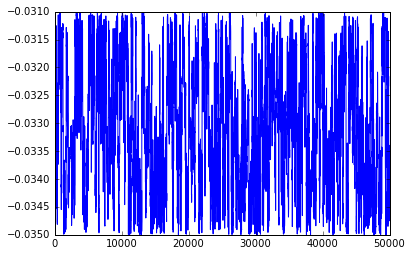

In [156]:
ind=4
plt.plot(np.arange(len(sampler.flatchain[:,ind])),sampler.flatchain[:,ind])

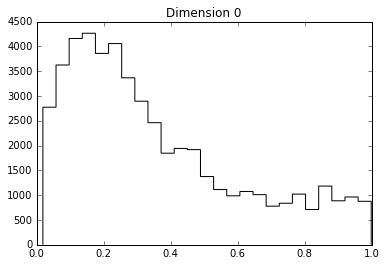

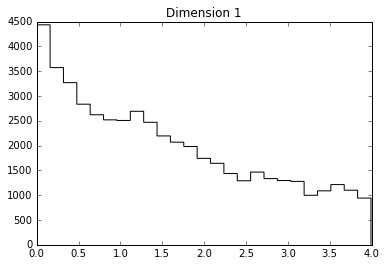

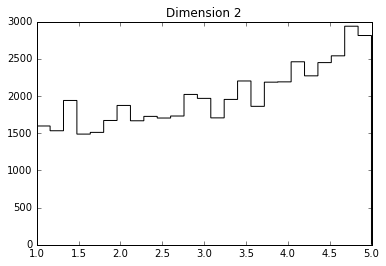

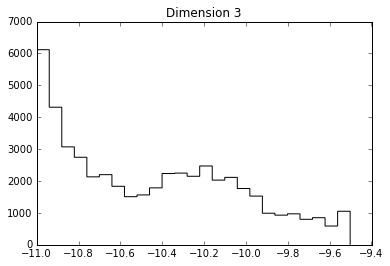

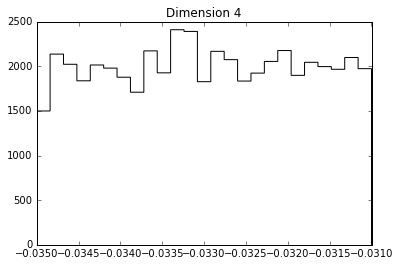

In [160]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 25, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

272100 51814


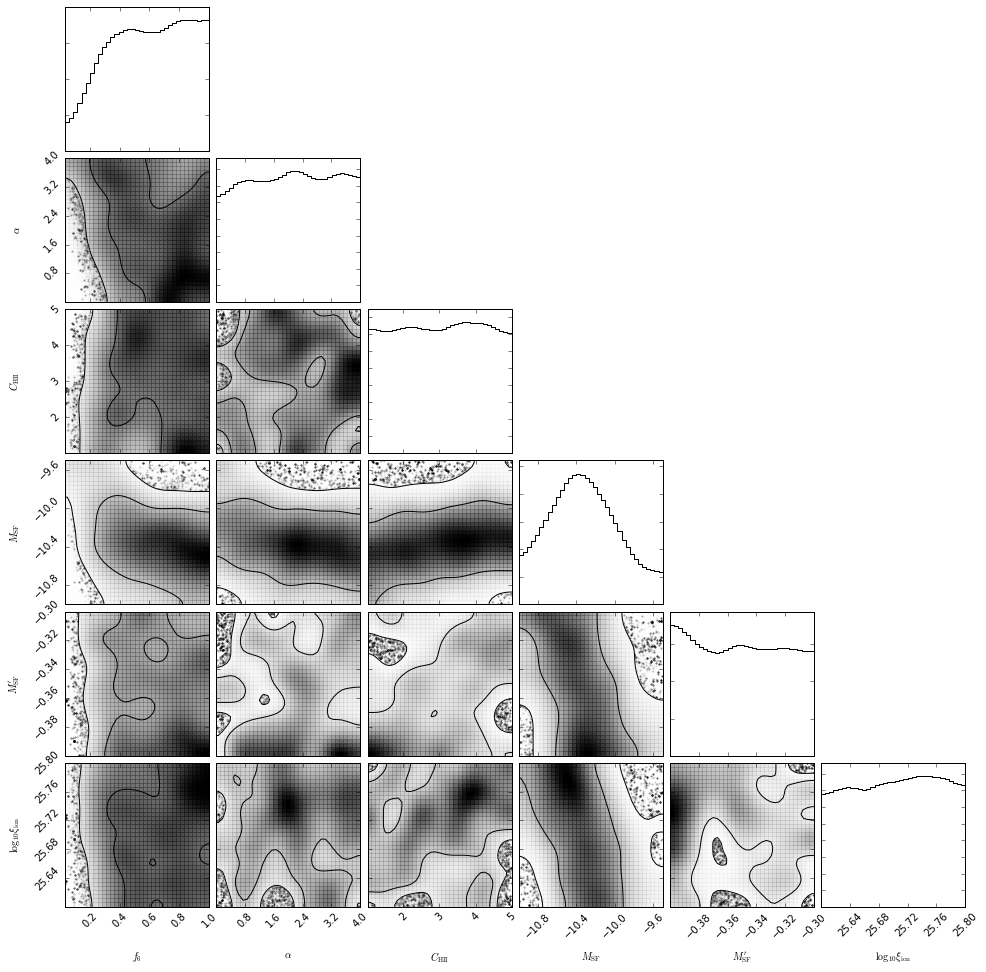

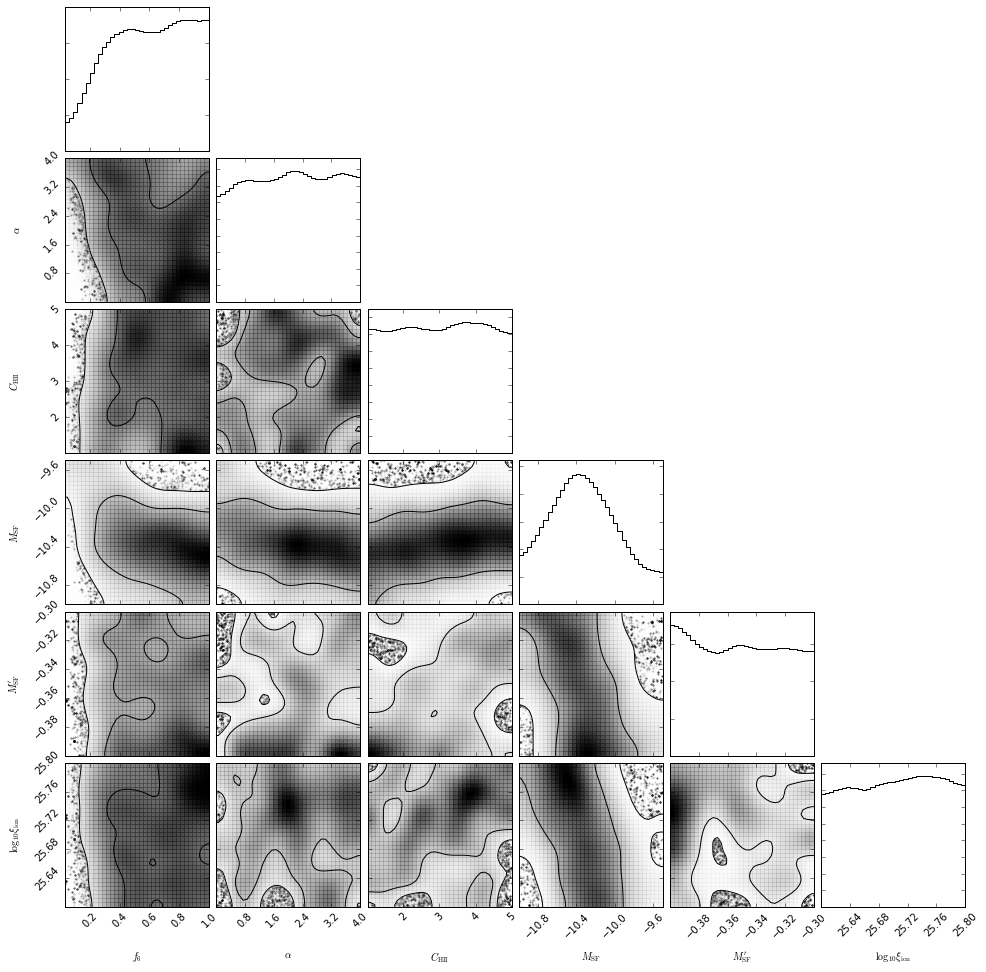

In [83]:
import corner

data = np.loadtxt('/Users/laynep/work/reionization/importance_sampler/python_implementation/'+'chain_power.dat')

to_plot = data[50000:,:]
to_plot2 = []
for here in to_plot:
    if here[-1]>25.6 and here[-1]<25.8 :# and here[3]<4 and here[3]>2:
        #here[-1]=10.0**here[-1]
        to_plot2.append(here)
to_plot = np.array(to_plot2)
#to_plot = to_plot[0::2,:]
print len(data), len(to_plot)
to_plot = to_plot[:,1:]

corner.corner(to_plot,
             labels=[r'$f_6$',r'$\alpha$',r'$C_{\rm HII}$',r'$M_{\rm SF}$',r'$M_{\rm SF}^\prime$',r'$\log_{10} \xi_{\rm ion}$'],
             levels=[0.68,0.95],
             bins=35,
             #quantiles=[0.5,0.9],
             plot_contours=True,
             smooth1d=2.5,
             smooth=3.0)

In [183]:
post_funct = interp1d(globe.tau_list, globe.taupdf_list,kind='cubic')

xvals = np.linspace(0.06,0.08,100)
yvals = map(post_funct,xvals)

ValueError: A value in x_new is below the interpolation range.

In [250]:
corner.corner?

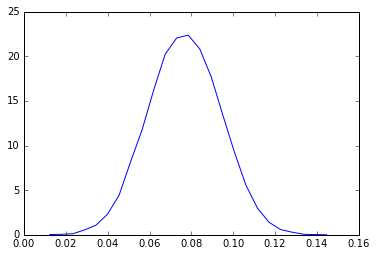

In [294]:
data = np.loadtxt('/Users/laynep/work/reionization/importance_sampler/python_implementation/posterior_margcosmo.txt')
plt.plot(data[:,1],data[:,0])

(-0.01, 1.02)

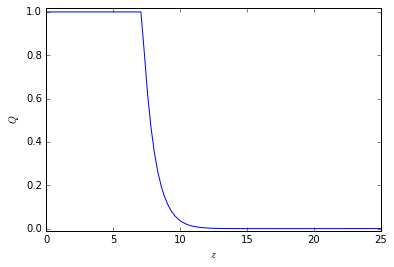

In [2]:
data = np.loadtxt('/Users/laynep/work/reionization/importance_sampler/python_implementation/Q_and_tau_data.txt')
plt.plot(data[:,0],data[:,1])
plt.xlabel(r'$z$')
plt.ylabel(r'$Q$')
plt.ylim([-0.01,1.02])

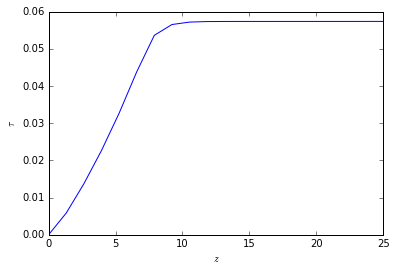

In [5]:
data = np.loadtxt('/Users/laynep/work/reionization/importance_sampler/python_implementation/tau_and_z_data.txt')
plt.plot(data[:,0],data[:,1])
plt.xlabel(r'$z$')
plt.ylabel(r'$\tau$')
#plt.ylim([-0.01,1.02])

In [52]:
#Best-fit Schecter parameters from 1506.01035

z_list = np.linspace(0,15,25)
M_list = -20.97 + 0.17*(z_list-6.0)
phi_list = 0.45*10.0**(-0.21*(z_list-6.0))*1e-3
alpha_list = -1.91 - 0.13*(z_list-6.0)

In [53]:
for out in zip(z_list,phi_list,M_list,alpha_list):
    print out[:]

(0.0, 0.0081886538637449251, -21.989999999999998, -1.1299999999999999)
(0.625, 0.0060528862687679718, -21.883749999999999, -1.2112499999999999)
(1.25, 0.0044741703327883043, -21.7775, -1.2925)
(1.875, 0.0033072156452193823, -21.671250000000001, -1.3737499999999998)
(2.5, 0.0024446264917159493, -21.564999999999998, -1.4549999999999998)
(3.125, 0.0018070181461067088, -21.458749999999998, -1.5362499999999999)
(3.75, 0.0013357110345584588, -21.352499999999999, -1.6174999999999999)
(4.375, 0.00098733041042514897, -21.24625, -1.69875)
(5.0, 0.00072981454381151856, -21.140000000000001, -1.7799999999999998)
(5.625, 0.00053946405654563224, -21.033749999999998, -1.8612499999999998)
(6.25, 0.00039876085064677493, -20.927499999999998, -1.9424999999999999)
(6.875, 0.00029475590464123752, -20.821249999999999, -2.0237499999999997)
(7.5, 0.00021787756541284469, -20.715, -2.105)
(8.125, 0.00016105066179423059, -20.608750000000001, -2.1862499999999998)
(8.75, 0.00011904537126258222, -20.502499999999998,

0.0 0.0675
0.0 0.0681457142857
0.0 0.0687914285714
0.265274506059 0.0694371428571
0.265274506059 0.0700828571429
1.85692154241 0.0707285714286
1.06109802424 0.0713742857143
6.89713715753 0.07202
7.42768616965 0.0726657142857
14.5900978332 0.0733114285714
24.9358035695 0.0739571428571
32.6287642452 0.0746028571429
48.5452346088 0.0752485714286
77.4601557692 0.0758942857143
89.928057554 0.07654
109.293096496 0.0771857142857
126.005390378 0.0778314285714
142.71768426 0.0784771428571
147.227350863 0.0791228571429
142.71768426 0.0797685714286
132.637253029 0.0804142857143
122.556821799 0.08106
91.7849790964 0.0817057142857
73.4810381783 0.0823514285714
59.1562148511 0.0829971428571
38.9953523907 0.0836428571429
21.4872349908 0.0842885714286
15.1206468454 0.0849342857143
11.6720782666 0.08558
3.97911759088 0.0862257142857
1.59164703635 0.0868714285714
1.59164703635 0.0875171428571
0.265274506059 0.0881628571429
0.0 0.0888085714286
0.530549012118 0.0894542857143


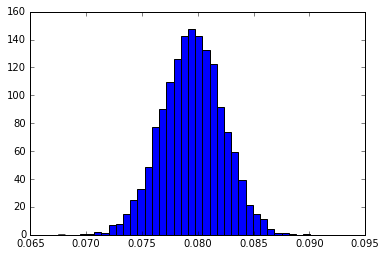

In [44]:
data = np.loadtxt('/Users/laynep/work/reionization/importance_sampler/python_implementation/'+'lcdm_tau.txt')

histbins = plt.hist(data,bins=35,range=[0.0675,0.0901],normed=True)

for x in zip(histbins[0],histbins[1]):
    print x[0],x[1]

In [30]:
plt.hist?